In [ ]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 6.1 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import yfinance as yf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Number of rows and columns after removing missing values: (2074, 7)
The time series starts from:  2013-12-16 00:00:00
The time series ends on:  2022-03-11 00:00:00
Statistics=272.688, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: -0.0034384356682428674
Skewness of normal distribution: 1.0666842843474564


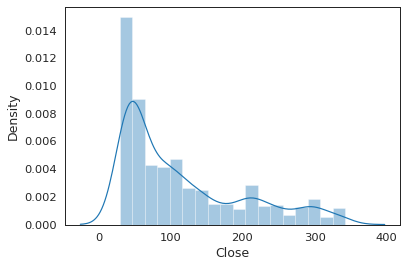

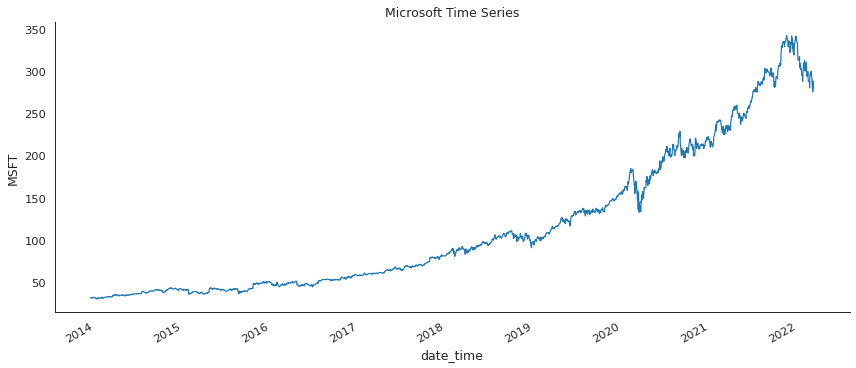

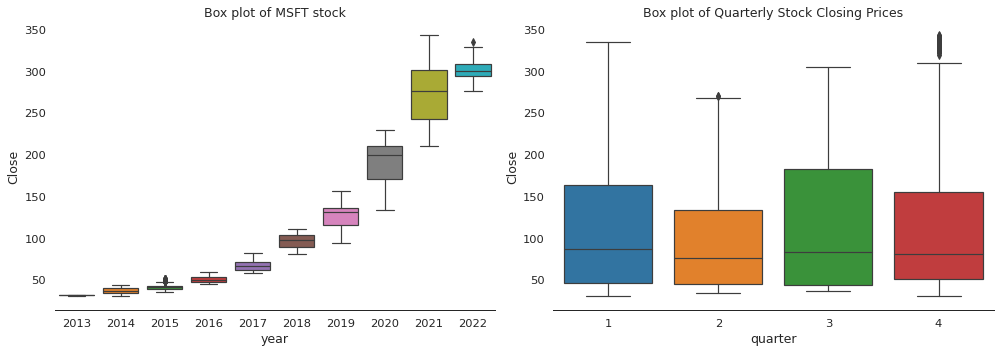

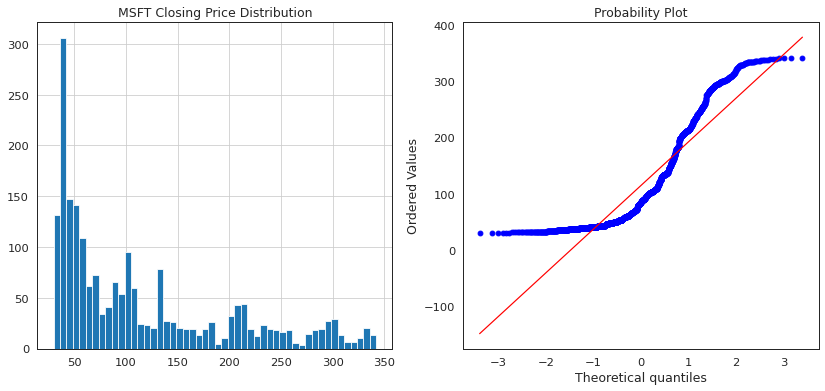

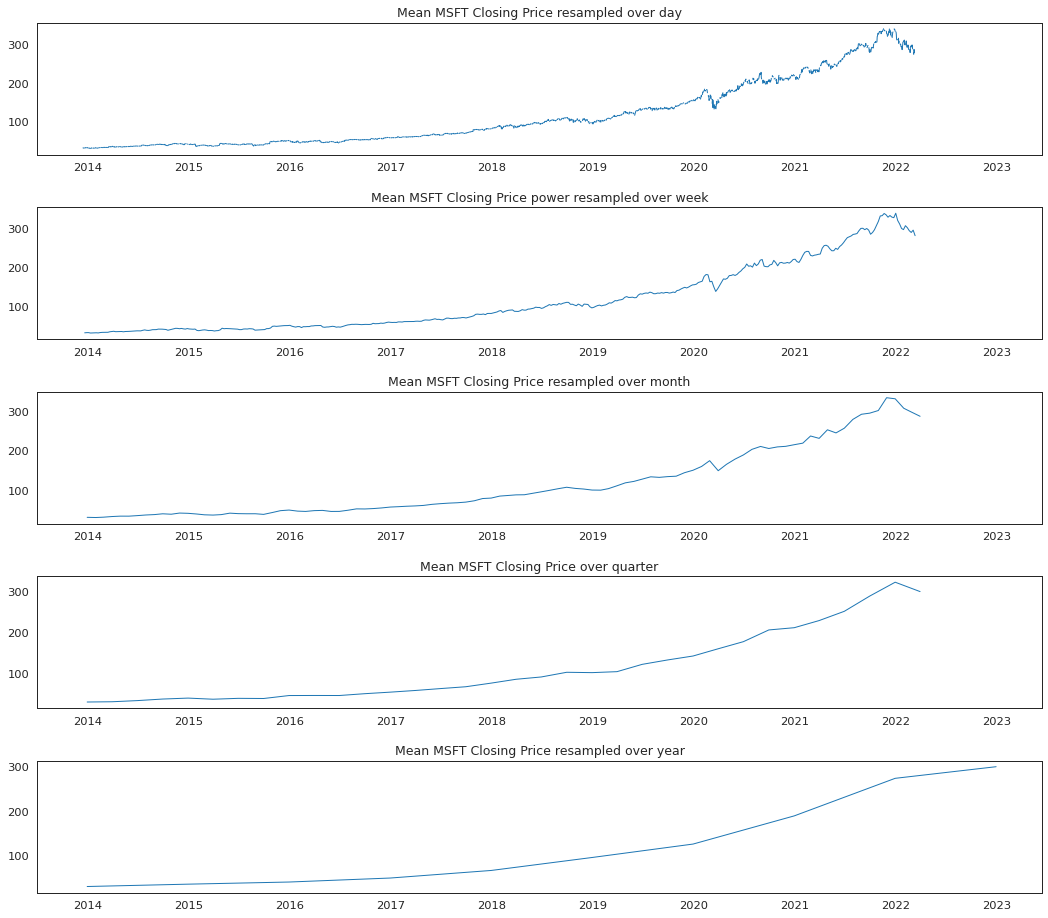

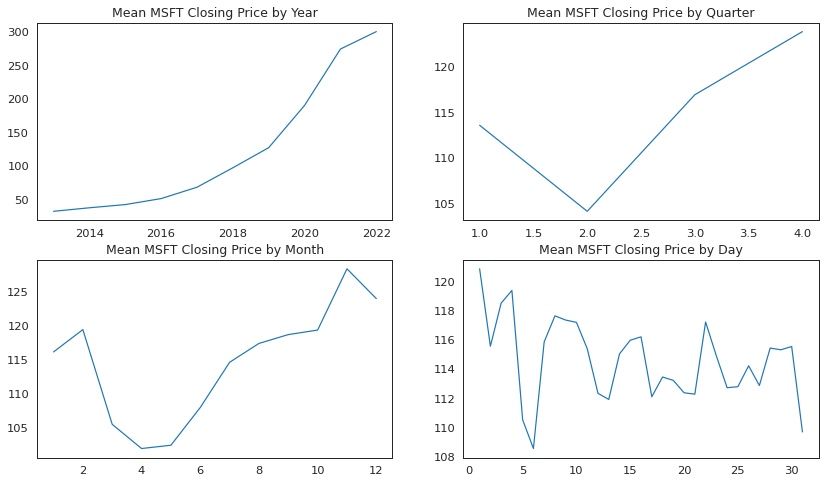

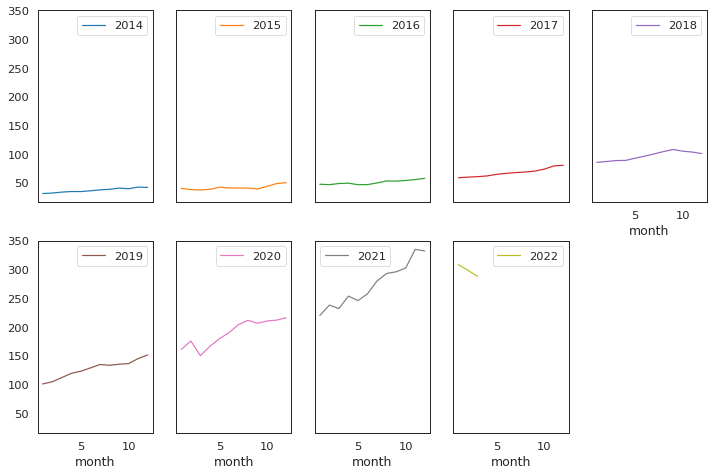

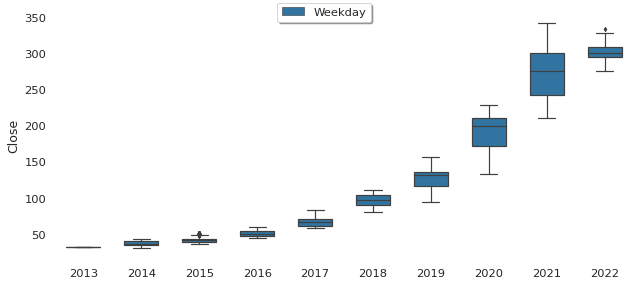

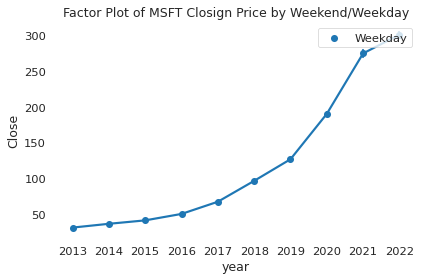

In [ ]:
msft = yf.Ticker("MSFT")
df = msft.history(period="max")
df = df.iloc[7000:]
df = df.reset_index()

df['date_time'] = df['Date']
df = df.dropna()
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Close', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

stat, p = stats.normaltest(df.Close)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

sns.distplot(df.Close);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Close)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Close)))

df1=df.loc[:,['date_time','Close']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('MSFT')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Microsoft Time Series')
sns.despine(top=True)
plt.show();

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Close", data=df)
plt.xlabel('year')
plt.title('Box plot of MSFT stock')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Close", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Stock Closing Prices')
sns.despine(left=True)
plt.tight_layout();

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Close'].hist(bins=50)
plt.title('MSFT Closing Price Distribution')
plt.subplot(1,2,2)
stats.probplot(df['Close'], plot=plt);
df1.describe().T

fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Close'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean MSFT Closing Price resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Close'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean MSFT Closing Price power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Close'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean MSFT Closing Price resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Close'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean MSFT Closing Price over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Close'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean MSFT Closing Price resampled over year')
ax5.tick_params(axis='both', which='major');

plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Close.agg('mean').plot()
plt.xlabel('')
plt.title('Mean MSFT Closing Price by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Close.agg('mean').plot()
plt.xlabel('')
plt.title('Mean MSFT Closing Price by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Close.agg('mean').plot()
plt.xlabel('')
plt.title('Mean MSFT Closing Price by Month')

plt.subplot(2,2,4)
df.groupby('day').Close.agg('mean').plot()
plt.xlabel('')
plt.title('Mean MSFT Closing Price by Day');


pd.pivot_table(df.loc[df['year'] != 2013], values = "Close", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','Close',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

plt1=sns.factorplot('year','Close',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of MSFT Closign Price by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');


Scraping companiesmarketcap.com for top 100 companies per industry by market cap (for the explanatory)

In [ ]:
urls = [
    'https://companiesmarketcap.com/automakers/largest-automakers-by-market-cap/',
    'https://companiesmarketcap.com/automakers/largest-automakers-by-market-cap/',
    'https://companiesmarketcap.com/airlines/largest-airlines-by-market-cap/',
    'https://companiesmarketcap.com/airports/largest-airport-operating-companies-by-market-cap/',
    'https://companiesmarketcap.com/aircraft-manufacturers/largest-aircraft-manufacturers-by-market-cap/',
    'https://companiesmarketcap.com/banks/largest-banks-by-market-cap/',
    'https://companiesmarketcap.com/hotels/largest-hotel-companies-by-market-cap/',
    'https://companiesmarketcap.com/pharmaceuticals/largest-pharmaceutical-companies-by-market-cap/',
    'https://companiesmarketcap.com/e-commerce/largest-e-commerce-companies-by-market-cap/',
    'https://companiesmarketcap.com/healthcare/largest-healthcare-companies-by-market-cap/',
    'https://companiesmarketcap.com/ports/largest-port-operating-companies-by-market-cap/',
    'https://companiesmarketcap.com/professional-services/largest-professional-service-companies-by-market-cap/',
    'https://companiesmarketcap.com/food/largest-food-companies-by-market-cap/',
    'https://companiesmarketcap.com/restaurant-chains/largest-restaurant-chain-companies-by-market-cap/',
    'https://companiesmarketcap.com/software/largest-software-companies-by-market-cap/',
    'https://companiesmarketcap.com/semiconductors/largest-semiconductor-companies-by-market-cap/',
    'https://companiesmarketcap.com/tobacco/largest-tobacco-companies-by-market-cap/',
    'https://companiesmarketcap.com/financial-services/largest-financial-service-companies-by-market-cap/',
    'https://companiesmarketcap.com/oil-gas/largest-oil-and-gas-companies-by-market-cap/',
    'https://companiesmarketcap.com/electricity/largest-electricity-companies-by-market-cap/',
    'https://companiesmarketcap.com/delivery-services/largest-delivery-companies-by-market-cap/',
    'https://companiesmarketcap.com/media-press/largest-media-and-press-companies-by-market-cap/',
    'https://companiesmarketcap.com/alcoholic-beverages/largest-alcoholic-beverage-companies-by-market-cap/',
    'https://companiesmarketcap.com/beverages/largest-beverage-companies-by-market-cap/',
    'https://companiesmarketcap.com/clothing/largest-clothing-companies-by-market-cap/',
    'https://companiesmarketcap.com/mining/largest-mining-companies-by-market-cap/',
    'https://companiesmarketcap.com/railways/largest-railways-companies-by-market-cap/',
    'https://companiesmarketcap.com/insurance/largest-insurance-companies-by-market-cap/',
    'https://companiesmarketcap.com/real-estate/largest-real-estate-companies-by-market-cap/',
    'https://companiesmarketcap.com/chemicals/largest-chemical-companies-by-market-cap/',
    'https://companiesmarketcap.com/investment/largest-investment-companies-by-market-cap/',
    'https://companiesmarketcap.com/telecommunication/largest-telecommunication-companies-by-market-cap/',
    'https://companiesmarketcap.com/retail/largest-retail-companies-by-market-cap/',
    'https://companiesmarketcap.com/internet/largest-internet-companies-by-market-cap/',
    'https://companiesmarketcap.com/construction/largest-construction-companies-by-market-cap/',
    'https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/'
]
a = []
for x in range(len(urls)):
    a.append(urls[x].split('/')[3])
a

import requests
import time
import bs4
from bs4 import BeautifulSoup
cats = ['automakers','airlines','aircraft-manufacturers','banks','pharmaceuticals','e-commerce','healthcare','ports','professional-services','food','restaurant-chains','software','semiconductors','tobacco','financial-services','electricity','courier-services','media/press','alcoholic-beverages','beverages','clothing','mining','railways','insurance','real-estate','chemicals','investment','telecomunication','retail','internet','construction','tech']
cat_names = {'category':[],'names':[],'ticker':[]}
try:
    for x in range(len(urls)):
        url = urls[x]
        html = requests.get(url).text
        soup = bs4.BeautifulSoup(html, "html.parser")
        for tag in soup.findAll("div", {"class": "name-div"}):
                cat_names['names'].append(tag.findNext("div").text)
                cat_names['category'].append(a[x])
        for tag in soup.findAll("div", {"class": "company-name"}):
                cat_names['ticker'].append(tag.findNext().text)

except:
    print(x)

In [81]:
ticker = 'aapl'
shift = 1
start_date = '2021-09-03'
category = 'tech'


cat_names = pd.DataFrame(cat_names)
tech = cat_names['ticker'][cat_names['category']==category]

for x in range(len(tech)):
      xx  = yf.Ticker(tech.iloc[x])
      df = xx.history(period="max")
      df.columns.values[0] = tech.iloc[x]+" Open"
      df.columns.values[1] = tech.iloc[x]+" High"
      df.columns.values[2] = tech.iloc[x]+" Low"
      df.columns.values[3] = tech.iloc[x]+" Close"
      df.columns.values[4] = tech.iloc[x]+" Volume"
      df.columns.values[5] = tech.iloc[x]+" Dividends"
      df.columns.values[6] = tech.iloc[x]+" Stock Splits"
      tech.iloc[x] = df.reset_index()
tech.iloc[1]

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import time
label_encoder = preprocessing.LabelEncoder()

msft = yf.Ticker(ticker)
df = msft.history(period="max")

for ii in range(len(tech)):
  if len(tech.iloc[ii])>500:
    df = pd.merge(df, tech.iloc[ii] ,on = 'Date')
  else:
    print('no '+tech.iloc[ii].columns[3].split()[0])

tech = cat_names['ticker'][cat_names['category']=='tech']
aa = pd.DataFrame()
vol = pd.DataFrame()
ss = []
for i in range(len(tech)):
  try:
    aa[str(tech.iloc[i])] = df[str(tech.iloc[i])+' Close']- df[str(tech.iloc[i])+' Open']
    vol[str(tech.iloc[i])] = df[str(tech.iloc[i])+' Volume']
  except:
    ss.append(str(tech.iloc[i]))
aa = round(aa)

tech = tech.drop(columns = [ss])
tech = [item for item in tech if item.isalpha()]
tech = pd.DataFrame(tech)
dd = pd.DataFrame()

rr = pd.DataFrame()
for x in range(len(tech)):
  try:
    rr[tech.iloc[x]] = aa[tech.iloc[1]]
  except:
    print(tec.iloc[x])



no ABNB
no SNOW
no COIN
no XIACF
no 1024.HK
no GFS
no CPNG
no DASH


In [119]:

qq = pd.DataFrame()
for x in range(len(tech)):
  try:
    qq[tech.iloc[x]] = aa[tech.iloc[x]]
  except:
    print(tech.iloc[x])



ss = []
df = pd.DataFrame()

for x in range(len(tech)):
  try:
    df = qq.drop(columns = tech[0][x])
    ss.append(df)
  except:
    print(tech[0][x])


pieces = []
for x in range(len(tech)):
  try:
    pieces.append(ss[x])
  except:
    print(tech[0][x])
df_final = pd.concat(pieces,axis = False, ignore_index = True)


tt = df_final
for x in range(len(tech)):
  try:
    tt[tech[0][x]].fillna(value=tt[tech[0][x]].mean(), inplace=True)
  except:
    print(tech[0][x])


y = []
for x in range(len(tech)):
  try:
    y.append(qq[tech[0][x]])
  except:
    print(tech[0][x])
yy = pd.concat(y, ignore_index = True)

yy

tt = round(tt)





0    
Name: 31, dtype: object
0    SNOW
Name: 51, dtype: object
0    COIN
Name: 69, dtype: object
0    XIACF
Name: 70, dtype: object
0    GFS
Name: 82, dtype: object
0    CPNG
Name: 85, dtype: object
0    DASH
Name: 90, dtype: object

SNOW
COIN
XIACF
GFS
CPNG
DASH
ALGN
CPNG
ZM
ERIC
EXPE
NET
DASH

SNOW
COIN
XIACF
GFS
CPNG
DASH

SNOW
COIN
XIACF
GFS
CPNG
DASH


In [ ]:
tt = tt.shift(shift*-1)
y = yy.shift(shift)

x = tt.dropna()
y = y.dropna()

y = y

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
clf=RandomForestClassifier(n_estimators=10000)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))



In [43]:
oo = tt
y = tt['AAPL']
tt = tt.drop(columns = ['AAPL'])
tt = tt.fillna(tt.mean())


oo = oo.shift(1*-1)
y = y.shift(1)

x = oo.dropna()
y = y.dropna()

y_test = y

y_pred=clf.predict(x)
print(metrics.accuracy_score(y_test, y_pred))


ValueError: ignored

In [52]:
df_pred = pd.DataFrame()
df_pred['pred'] = list(y_pred)
df_pred['test'] = y_test
df_pred[9950:]

,pred,test
9950,-1.0000,NaN
9951,3.0000,NaN
9952,-0.0000,NaN
9953,-1.0000,1.0000
9954,1.0000,NaN
...,...,...
10023,-0.0000,NaN
10024,-0.0000,NaN
10025,-0.0000,NaN
10026,-6.0000,2.0000


In [54]:
list(y_test)

[-1.0,
 -3.0,
 0.0,
 3.0,
 5.0,
 8.0,
 -1.0,
 1.0,
 0.0,
 4.0,
 2.0,
 -2.0,
 -6.0,
 -3.0,
 -2.0,
 1.0,
 1.0,
 5.0,
 -5.0,
 2.0,
 0.0,
 -1.0,
 1.0,
 2.0,
 4.0,
 -0.0,
 -0.0,
 4.0,
 1.0,
 -4.0,
 -4.0,
 -1.0,
 1.0,
 0.0,
 0.0,
 6.0,
 -2.0,
 -3.0,
 -6.0,
 1.0,
 -0.0,
 -5.0,
 -3.0,
 -1.0,
 -0.0,
 -2.0,
 -6.0,
 -0.0,
 3.0,
 -2.0,
 -5.0,
 5.0,
 0.0,
 -4.0,
 3.0,
 1.0,
 2.0,
 -1.0,
 2.0,
 3.0,
 5.0,
 -3.0,
 4.0,
 -0.0,
 -1.0,
 5.0,
 -4.0,
 3.0,
 5.0,
 -11.0,
 -1.0,
 2.0,
 3.0,
 -1.0,
 0.0,
 -1.0,
 1.0,
 1.0,
 2.0,
 4.0,
 5.0,
 1.0,
 -6.0,
 -4.0,
 -3.0,
 1.0,
 -0.0,
 -7.0,
 0.0,
 4.0,
 -1.0,
 -1.0,
 4.0,
 0.0,
 3.0,
 3.0,
 3.0,
 6.0,
 3.0,
 -3.0,
 -0.0,
 1.0,
 -6.0,
 1.0,
 1.0,
 0.0,
 5.0,
 0.0,
 -6.0,
 -6.0,
 -2.0,
 -0.0,
 -3.0,
 -1.0,
 0.0,
 -1.0,
 2.0,
 -0.0,
 0.0,
 0.0,
 3.0,
 1.0,
 5.0,
 -1.0,
 -0.0,
 -3.0,
 -1.0,
 -1.0,
 -8.0,
 -1.0,
 5.0,
 -1.0,
 -2.0,
 0.0,
 1.0,
 -3.0,
 1.0,
 1.0,
 -4.0,
 -0.0,
 4.0,
 -2.0,
 2.0,
 1.0,
 -5.0,
 2.0,
 3.0,
 -2.0,
 8.0,
 1.0,
 -7.0,
 -2.0,
 2.0,
 2.0,
 1.

In [ ]:
#SCRAP YARD / NEXT STEPS: volume to allow random forest

In [ ]:
#multinomial logistic regression model
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
# define dataset
x, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
#gradient boosted
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

#gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
#gb_clf2.fit(X_train, y_train)
#predictions = gb_clf2.predict(X_val)

#print("Confusion Matrix:")
#print(confusion_matrix(y_val, predictions))

#print("Classification Report")
#print(classification_report(y_val, predictions))



In [ ]:
#xgboost classifier
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
score = xgb_clf.score(X_test, y_test)
print(score)


SCRAP YARD